# Минипроект 6

In [55]:
import pandas as pd
import numpy as np

import requests
import json
from urllib.parse import urlencode
from io import BytesIO

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
import gc
import vk_api

import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Задание 1

Для начала, давайте посмотрим на распределение посещений сайта по дням. Постройте график с распределением количества посещений от ботов и обычных пользователей сайта Яндекс.Метрика с 2022-12-11 по 2022-12-13

Hint: для получения нужных данных понадобится фильтр по дате и параметр isRobots

Hint2: чтобы применить фильтр по дате воспользуйтесь &filters=ym:s:date=='date_which_you_need'

In [3]:
# Базовая ссылка без параметров

url = 'https://api-metrika.yandex.net/stat/v1/data?'

In [4]:
# Список дат из рассматриваемого временного промежутка

dates = ['2022-12-11', '2022-12-12', '2022-12-13'] 

In [5]:
df = pd.DataFrame()

In [6]:
for date in dates:
    
    # Зададим параметры, добавляющиеся к базовой ссылке
    params = {
                'metrics': 'ym:s:visits',
                'dimensions': ['ym:s:date', 'ym:s:isRobot'],
                'filters': f"ym:s:date=='{date}'",
                'id': 44147844
            }

    visits = urlencode(params, doseq = True) # doseq = True, тк есть список параметров
   
    # Полная ссылка
    link = url + visits
    
    # Получаем ответ после переходу на ссылку
    response = requests.get(link)
    
    # Преобразуем полученный ответ в json формат
    json_data = response.json()
    
    
    for record in json_data['data']:
        
        # Создаем список, где 0 элемент - дата, 1 - тип пользователя, 2 - количество посетителей 
        #(для каждой итерации чистится)
        lst = []
        
        dimensions_data = record['dimensions'] 
        metriq_data = record['metrics'][0]

        for i in dimensions_data:
            lst.append(i['name']) # добавляем в список сначала дату, потом тип пользователя
        
        lst.append(metriq_data) # добавляем в список количество посетителей
        
        
        # Добавляем новую строчку в датафрейм 
        df = df.append([lst])

In [7]:
df

,0,1,2
0,2022-12-11,People,356.0
0,2022-12-11,Robots,27.0
0,2022-12-12,People,677.0
0,2022-12-12,Robots,37.0
0,2022-12-13,People,700.0
0,2022-12-13,Robots,34.0


Получаются ссылки следующего вида:

https://api-metrika.yandex.net/stat/v1/data?metrics=ym:s:visits&dimensions=ym:s:date&filters=ym:s:date=='2022-12-11'&dimensions=ym:s:isRobot&id=44147844

In [8]:
# Дадим колонкам имена

df.columns = ['date', 'type', 'visits_count']

In [9]:
df

,date,type,visits_count
0,2022-12-11,People,356.0
0,2022-12-11,Robots,27.0
0,2022-12-12,People,677.0
0,2022-12-12,Robots,37.0
0,2022-12-13,People,700.0
0,2022-12-13,Robots,34.0


<AxesSubplot:xlabel='date', ylabel='visits_count'>

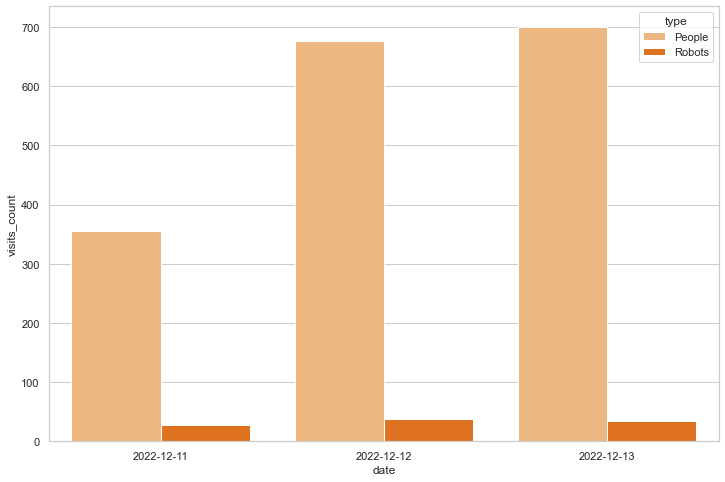

In [10]:
# Настройки графиков

sns.set(style = 'whitegrid',
       rc = {'figure.figsize': (12, 8)},
       palette = 'gist_heat_r'
        )
# Построение графика
sns.barplot(data = df, x = "date", y = "visits_count", hue = "type")

### Задание 2
Скачайте файл с данными посещаемости сайта Яндекс.Метрика step_2_lesson_7.csv. При помощи функции np.where создайте серию, в которую будет записываться 1, если посещения были сделаны роботами с браузера, содержащего Chrome в названии и 0, в других случаях. Поместите получившуюся серию в переменную chrome_robots

Hint: ответ должен быть в форме pd. Series

Hint2: в numpy более жёсткие требования к логическим действиям чем в pandas - выражения должны быть окружены скобками и вместо or/and нужно писать | или &

Может понадобиться:
- str.contains( )

In [11]:
df_step_2 = pd.read_csv('/Users/ola/Documents/Karpov/7. Знакомство с API/step_2_lesson_7.csv')

In [12]:
df_step_2.head()

,date,browser,user_type,visits
0,2020-06-15,Google Chrome,People,250.0
1,2020-06-15,Google Chrome,Robots,104.0
2,2020-06-15,Yandex Browser,People,47.0
3,2020-06-15,Firefox,Robots,31.0
4,2020-06-15,Chrome Mobile,People,31.0


In [13]:
# Запишем в переменную chrome_robots массив в котором будет 1,
# если посещения были сделаны роботами с браузера, содержащего Chrome в названии и 0, в других случаях. 

chrome_robots = np.where((df_step_2['browser'].str.contains('Chrome')) & (df_step_2['user_type'] == 'Robots'), 1, 0)
chrome_robots

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [14]:
# Преобразуем полученный массив к типу pd.Series и перезапишем в переменную chrome_robots

chrome_robots = pd.Series(chrome_robots)
chrome_robots

0     0
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
dtype: int64

### Задание 3

Давайте выясним, с какого браузера приходит меньше всего ботов. Посмотрите на данные за 10 декабря (2022-12-10) и определите, у какого браузера самая маленькая доля посещений сайта ботами от общего числа посещений?
В качестве ответа укажите название браузера.

Hint: а тут нужны все параметры, которые мы использовали до этого

Hint2: то есть фильтр по дате, browser, isRobot тут нужны все параметры, которые мы использовали до этого

#### 1. Импорт данных

In [15]:
# Зададим параметры, добавляющиеся к базовой ссылке

params = {
                'metrics': 'ym:s:visits',
                'dimensions': ['ym:s:date', 'ym:s:isRobot', 'ym:s:browser'],
                'filters': f"ym:s:date=='2022-12-10'",
                'id': 44147844
        }

In [16]:
visits_per_browser = urlencode(params, doseq = True) # doseq = True, тк есть список параметров

In [17]:
link = url + visits_per_browser

In [18]:
# Получаем ответ после перехода на ссылку

response = requests.get(link)

In [19]:
# Преобразуем полученный ответ в json формат

json_data = response.json()

In [20]:
# Cоздаем пустой датафрейм

visits_per_browser_df = pd.DataFrame()

In [21]:
for record in json_data['data']:
        
        # Создаем список, где 0 элемент - дата, 1 - тип пользователя, 2 - браузер, 3 - количество посетителей 
        #(для каждой итерации чистится)
        lst = []
        
        dimensions_data = record['dimensions'] 
        metriq_data = record['metrics'][0]

        for i in dimensions_data:
            lst.append(i['name']) # добавляем в список сначала дату, потом тип пользователя
        
        lst.append(metriq_data) # добавляем в список количество посетителей
        
        
        # Добавляем новую строчку в датафрейм 
        visits_per_browser_df = visits_per_browser_df.append([lst])

In [22]:
# Дадим названия столбцам

visits_per_browser_df.columns = ['date', 'user_type', 'browser', 'visits']

#### 2. Узнаем, с какого браузера приходит меньше всего  ботов

In [23]:
visits_per_browser_df.head()

,date,user_type,browser,visits
0,2022-12-10,People,Chrome Mobile,114.0
0,2022-12-10,People,Google Chrome,102.0
0,2022-12-10,People,Yandex Browser,67.0
0,2022-12-10,People,Safari,27.0
0,2022-12-10,People,Mobile Safari,13.0


In [24]:
# Посчитаем общее количество визитов на сайт для каждого браузера

all_visits_df = visits_per_browser_df.groupby('browser', as_index = False).agg({'visits': 'sum'})
all_visits_df.head()

,browser,visits
0,Android Browser,2.0
1,Atom,1.0
2,Chrome Mobile,124.0
3,Edge,14.0
4,Firefox,10.0


In [25]:
# Добавим в visits_per_browser_df данные об общем количестве визитов на сайт для каждого браузера
# в качестве столбца all_visits_df

visits_per_browser_df = visits_per_browser_df \
                                            .merge(all_visits_df, on = 'browser') \
                                            .rename(columns = {'visits_x': 'visits', 'visits_y': 'all_visits'})

In [26]:
# Создадим колонку с долей посещений сайта

visits_per_browser_df['ratio'] = visits_per_browser_df['visits'] / visits_per_browser_df['all_visits']

In [27]:
# Отберем только данные, где user_type == Robots и отстортируем по возрастанию доли посещений

visits_per_browser_df \
                        .query('user_type == "Robots"') \
                        .sort_values('ratio')
                        #.nsmallest (1, columns = 'ratio')


,date,user_type,browser,visits,all_visits,ratio
5,2022-12-10,Robots,Yandex Browser,3.0,70.0,0.042857
3,2022-12-10,Robots,Google Chrome,5.0,107.0,0.046729
8,2022-12-10,Robots,Mobile Safari,1.0,14.0,0.071429
1,2022-12-10,Robots,Chrome Mobile,10.0,124.0,0.080645
14,2022-12-10,Robots,Firefox,1.0,10.0,0.100000
11,2022-12-10,Robots,Edge,3.0,14.0,0.214286
16,2022-12-10,Robots,Yandex Start: mobile app,2.0,8.0,0.250000
20,2022-12-10,Robots,Android Browser,1.0,2.0,0.500000
24,2022-12-10,Robots,Яндекс.Браузер lite,1.0,1.0,1.000000
25,2022-12-10,Robots,HeadlessChrome,1.0,1.0,1.000000


Самая маленькая доля посещений сайта ботами от общего числа посещений приходится на Yandex Browser

### Задание 4

Сагрегируйте данные по дню, типу пользователя, браузеру, создайте колонку с метрикой доли заходов на сайт для каждого из этих разрезов.

В ответе укажите процент открытий сайта настоящими пользователями Safari (не ботами) с точностью до 1 знака после точки.

PS: Данные нужны за 10 декабря

Заметим, что данные в датафрейме visits_per_browser_df уже сагрегированы. В нем есть колонка ratio, в которой расчитана доля посещений для конкретного браузера. Сейчас же нужно найти долю посещений от общего числа посещений за весь день.

In [28]:
# Добавим колонку percent, где будет записан процент посещений от общего количества посещений за 10 декабря

visits_per_browser_df['percent'] = (visits_per_browser_df['visits'] / visits_per_browser_df.visits.sum()) * 100

In [29]:
# Найдем процент открытий сайта настоящими пользователями Safari с точностью до 1 знака после точки

visits_per_browser_df.query('user_type == "People" and browser == "Safari"')['percent'].round(1)

6    6.6
Name: percent, dtype: float64

### Задание 5

При помощи библиотеки gspread отправьте данные из предыдущего шага в Google SpreadSheet. Далее отправьте ссылку на получившийся файл в Google SpreadSheet (не забудьте открыть доступ по ссылке, это можно сделать
вручную, когда данные уже зальются в таблицу) при помощи vк арі себе в личку ВКонтакте.

https://machinelearningmastery.ru/using-python-to-push-your-pandas-dataframe-to-google-sheets-de69422508f/

#### 1. Выгрузим датафрейм в Google Sheets

In [38]:
# Ссылка для получения доступа к гугл диск

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

my_mail = 'olyabazan333@gmail.com'

# Авторизация

credentials = ServiceAccountCredentials.from_json_keyfile_name('jsonFileFromGoogle.json', scope)
gc = gspread.authorize(credentials)

In [31]:
gc

In [32]:
# Ключ к гугл таблице (если создаем вручную)

spreadsheet_key = '1hijta8sMLQK5w_Q4Y8d9GmhdGukRDrZjBPNxjTXNVEc'

In [33]:
# Выгрузка датафрейма в гугл таблицу

d2g.upload(visits_per_browser_df,
           spreadsheet_key,
           credentials = credentials,
           row_names = True)

<Worksheet 'Лист1' id:0>

In [34]:
# Название таблицы


table_name = 'API test Py'

In [36]:
# Создание гугл таблицы 

gc.create(table_name)

<Spreadsheet 'API test Py' id:1SuciuAxKHWGeN99yf-CWw7xYjdSfJNYoO-PLp173sFw>

In [42]:
# Открыть таблицу

table = gc.open(table_name)

In [43]:
# Открыть доступ к таблице

table.share(my_mail, perm_type = 'user', role = 'writer')

<Response [200]>

In [45]:
# Выгрузка датафрейма в гугл таблицу

d2g.upload(visits_per_browser_df,
           table_name,
           'list1',
           credentials = credentials,
           row_names = True)

<Worksheet 'list1' id:1074597171>

#### 2. Отправим ссылку на таблицу в ВК

In [47]:
# Запишем в переменную token ключ доступа

token = ''

In [49]:
# Подключение к vk.com

vk_session = vk_api.VkApi(token = token)
vk = vk_session.get_api() # позволяет оръбращаться к методам ВК

In [52]:
# Отправим сообщение от лица группы

vk.messages.send(
        chat_id = 1,
        random_id = np.random.randint(0, 2 ** 31),
        message = "https://docs.google.com/spreadsheets/d/1SuciuAxKHWGeN99yf-CWw7xYjdSfJNYoO-PLp173sFw/edit?usp=sharing!"
                                     )

0

### Задание 6
Другой аналитик уже агрегировал часть данных из метрики, и вам нужно объединить усилия, чтобы получить финальный отчет. Прочитайте дополнительные данные из Google SpreadSheet, объедините вашу таблицу из предыдущего шага с таблицей аналитика и посчитайте количество визитов на человека (отношение visits K users ) в разрезе по браузеру и значениям Robots/People.

В ответе укажите, сколько визитов на уникального пользователя совершается ботами с браузера Google Chrome (округлите до целого)

Вот так можно прочитать данные другого аналитика:

In [56]:
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQWMsvBTVio9C7IOOxfFO9C15BRHyME-_ENHqBodDOjuiHwk9fCuF5hUVmDs497PZOqPYK3exdSikOK/pub?gid=1006633900&single=true&output=csv')

In [59]:
data = r.content

In [62]:
df_from_analyst = pd.read_csv(BytesIO(data))

In [69]:
# Исправим ошибку в дате

df_from_analyst['date'] = df_from_analyst['date'].replace('2020-06-15', '2022-12-10')

In [79]:
# Объеденим датафреймы и перезапишем в visits_per_browser

visits_per_browser = visits_per_browser_df.merge(df_from_analyst, on = ['date', 'browser', 'user_type'])

In [83]:
# Запишеv в колонку ratio_of_users_to_visits отношение пользователей к визитам

visits_per_browser['ratio_of_users_to_visits'] = visits_per_browser['users'] / visits_per_browser['visits']

In [84]:
visits_per_browser

,date,user_type,browser,visits,all_visits,ratio,percent,users,ratio_of_users_to_visits
0,2022-12-10,People,Chrome Mobile,114.0,124.0,0.919355,27.872861,30.0,0.263158
1,2022-12-10,People,Google Chrome,102.0,107.0,0.953271,24.938875,240.0,2.352941
2,2022-12-10,Robots,Google Chrome,5.0,107.0,0.046729,1.222494,104.0,20.800000
3,2022-12-10,People,Yandex Browser,67.0,70.0,0.957143,16.381418,44.0,0.656716
4,2022-12-10,Robots,Yandex Browser,3.0,70.0,0.042857,0.733496,7.0,2.333333
5,2022-12-10,People,Safari,27.0,27.0,1.000000,6.601467,17.0,0.629630
6,2022-12-10,People,Mobile Safari,13.0,14.0,0.928571,3.178484,14.0,1.076923
7,2022-12-10,Robots,Mobile Safari,1.0,14.0,0.071429,0.244499,1.0,1.000000
8,2022-12-10,People,Opera,12.0,12.0,1.000000,2.933985,10.0,0.833333
9,2022-12-10,People,Edge,11.0,14.0,0.785714,2.689487,4.0,0.363636


In [86]:
# Выясним, сколько визитов на уникального пользователя совершается ботами с браузера Google Chrome
# и округлим до целого

visits_per_browser \
                    .query('user_type == "Robots" and browser == "Google Chrome"') \
                    .ratio_of_users_to_visits \
                    .round()

2    21.0
Name: ratio_of_users_to_visits, dtype: float64